In [71]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
file_loc = '../datasets/manga.csv'
df = pd.read_csv(file_loc)

In [73]:
df.columns

Index(['manga_id', 'title', 'type', 'score', 'scored_by', 'status', 'volumes',
       'chapters', 'start_date', 'end_date', 'members', 'favorites', 'sfw',
       'approved', 'created_at_before', 'updated_at', 'real_start_date',
       'real_end_date', 'genres', 'themes', 'demographics', 'authors',
       'serializations', 'synopsis', 'background', 'main_picture', 'url',
       'title_english', 'title_japanese', 'title_synonyms'],
      dtype='object')

In [74]:
df_new = df[['manga_id','title','score','status','favorites','genres','type','start_date', 'chapters']]
df_new.head()

,manga_id,title,score,status,favorites,genres,type,start_date,chapters
0,2,Berserk,9.47,currently_publishing,119470,"['Action', 'Adventure', 'Award Winning', 'Dram...",manga,1989-08-25,NaN
1,13,One Piece,9.22,currently_publishing,111462,"['Action', 'Adventure', 'Fantasy']",manga,1997-07-22,NaN
2,1706,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,9.30,finished,41713,"['Action', 'Adventure', 'Mystery', 'Supernatur...",manga,2004-01-19,96.0
3,4632,Oyasumi Punpun,9.02,finished,49361,"['Drama', 'Slice of Life']",manga,2007-03-15,147.0
4,25,Fullmetal Alchemist,9.03,finished,29634,"['Action', 'Adventure', 'Award Winning', 'Dram...",manga,2001-07-12,116.0


In [75]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64833 entries, 0 to 64832
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   manga_id    64833 non-null  int64  
 1   title       64833 non-null  object 
 2   score       24636 non-null  float64
 3   status      64833 non-null  object 
 4   favorites   64833 non-null  int64  
 5   genres      64833 non-null  object 
 6   type        64833 non-null  object 
 7   start_date  62950 non-null  object 
 8   chapters    46042 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 4.5+ MB


In [76]:
df_new.isna().sum()
print(df_new.shape)

(64833, 9)


In [79]:
df_reg = df_new[['favorites', 'score']]
df_reg.isna().sum()

train_data = df_reg.dropna()  # Dropping rows with NaN values
X = train_data[['favorites']]
y = train_data['score']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# First model: Predict zero vs non-zero
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, (y_train == 0).astype(int))  # Convert to integer for classification

# Second model: Predict non-zero values
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train.loc[y_train != 0], y_train[y_train != 0])

# Combined model
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)
rf.fit(X_train, y_train)

# Making predictions
is_zero = classifier.predict(X_val).astype(bool)  # Ensure boolean indexing
final_pred = np.zeros_like(y_val)  # Initialize predictions with zeros

# Predict non-zero values only where classifier predicts non-zero
non_zero_indices = ~is_zero
final_pred[non_zero_indices] = regressor.predict(X_val.loc[non_zero_indices])

# Compute evaluation metrics
mse = mean_squared_error(y_val, final_pred)
r2 = r2_score(y_val, final_pred)

# Additional Random Forest model predictions
rf_preds = rf.predict(X_val)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

Mean Squared Error: 0.15
R² Score: 0.44


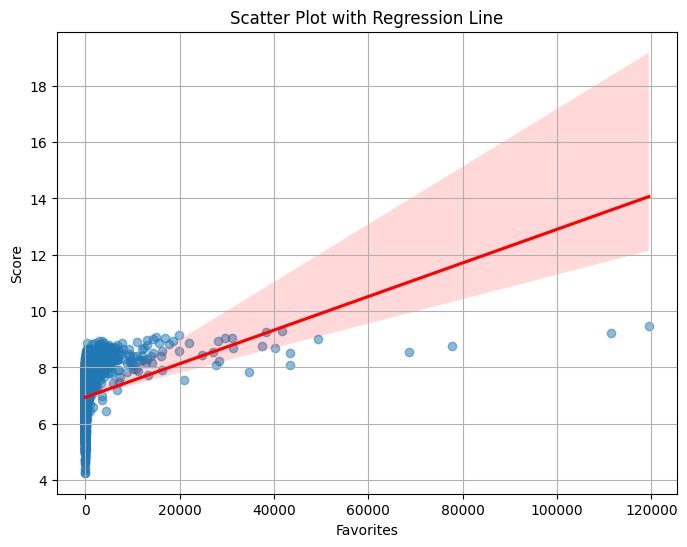

In [80]:
plt.figure(figsize=(8, 6))
sns.regplot(
    x=X_train.squeeze(),  # Ensure x is a Series
    y=y_train, 
    scatter_kws={'alpha': 0.5}, 
    line_kws={'color': 'red'}
)
plt.xlabel("Favorites")
plt.ylabel("Score")
plt.title("Scatter Plot with Regression Line")
plt.grid(True)  # Improve readability
plt.show()


In [ ]:
# Identify missing values in 'score'
missing_data = df_reg[df_reg['score'].isna()]
X_test = missing_data[['favorites']]

# Predict missing scores using the trained regressor
y_pred = rf.predict(X_test).round(2)  # Use 'rf' instead of 'regr' and round directly

# Fill missing values with predictions
df_reg.loc[df_reg['score'].isna(), 'score'] = y_pred

# Verify if missing values are filled
print(df_reg.isna().sum())  
print(df_reg.shape)

# Efficiently update df_new with corrected scores instead of merging
df_new.update(df_reg)
